In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load YOLO detector and then find indexes of targets (person, chair, laptop)

In [2]:
target_names = ['person', 'laptop', 'chair', 'tvmonitor'] # declare things to detect
def load_yolo(targets):
    # Load Yolo
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    targets = np.array([np.where(np.array(classes) == target) for target in target_names]).flatten() # find index of wanted targets
    #print(targets)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return net, output_layers, classes, targets

net, output_layers, classes, targets = load_yolo(target_names)

### Create a blob from image, put into network (net), and return outputs (outs)

In [3]:
def detect_objects(img, net, output_layers, size=(416, 416), swapRB=True, crop=False, scalefactor=0.00392):
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, scalefactor, size, (0, 0, 0), swapRB, crop=crop)
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    return outs

    


### If output objects found are above confidence level and in targets, get boxes and their indexes

In [4]:
# Showing informations on the screen
def find_indexes(targets, outs, dims,conf=0.9):
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf and class_id in targets:
                # Object detected
                center_x = int(detection[0] * dims[1])
                center_y = int(detection[1] * dims[0])
                w = int(detection[2] * dims[1])
                h = int(detection[3] * dims[0])

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) # non max suppression
    return indexes, class_ids, confidences, boxes

### Draw the boxes and add the labels

In [5]:
def draw_boxes_labels(img, boxes, indexes, class_ids, colors=(0,255,0)):
    font = cv2.FONT_HERSHEY_PLAIN
    height, width, dim = img.shape
    rect_thicc = int(height/70)
    if height < 400:
        rect_thicc = 2
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            font_size = int(h/200)+1
            font_width = int(h/100)+1
            label = str(classes[class_ids[i]])
            color = colors
            cv2.rectangle(img, (x, y), (x + w, y + h), color, rect_thicc)
            cv2.putText(img, label, (x, y - font_size), font, font_size, color, font_width)

### Do all the above functions (but loading yolo) on an image or frame of a video

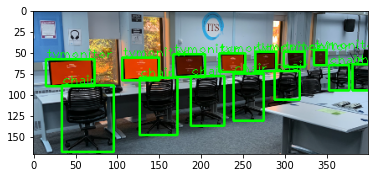

In [6]:
img = cv2.imread("lab1.jpg")

def yolo_frame(img):
    img = cv2.resize(img, None, fx=0.4, fy=0.4) # resize image
    outs = detect_objects(img, net, output_layers) # find all objects
    indexes, class_ids, confidences, boxes = find_indexes(targets, outs,img.shape, .2) # box object if object in targets
    draw_boxes_labels(img, boxes, indexes, class_ids) # update frame
    plt.imshow(img) # show frame
    
    
yolo_frame(img)

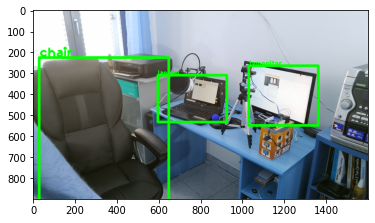

In [7]:
img2 = cv2.imread('room_ser.jpg')
yolo_frame(img2)

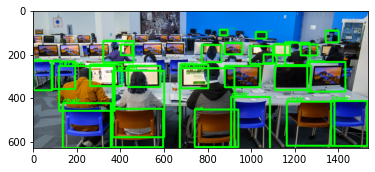

In [8]:
img3 = cv2.imread('lab2.jpg')
yolo_frame(img3)

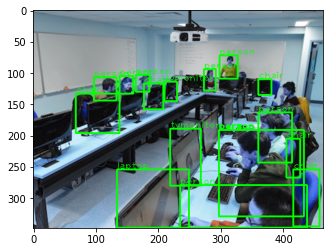

In [9]:
img4 = cv2.imread('lab3.jpg')
yolo_frame(img4)